
# Fraud Detection Project – ACCREDIAN Assignment

This notebook presents the process and results for predicting fraudulent transactions in a financial dataset. The analysis covers data cleaning, feature engineering, model development, evaluation, and actionable insights for proactive fraud detection.

---

## Objectives
The goal of this project is to develop a machine learning model to proactively detect fraudulent transactions in a financial dataset. The model should identify fraudulent patterns, help minimize losses, and provide actionable insights for preventive measures. The focus is on both statistical analysis and practical interpretability.

## Dataset Summary
- **Total Rows:** 6,362,620  
- **Total Columns:** 10  
- **Key Features:**  
  - `step`: time step (1 step = 1 hour, total 744 steps)  
  - `type`: transaction type (CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER)  
  - `amount`: transaction amount in local currency  
  - `nameOrig` / `nameDest`: sender and recipient accounts  
  - `oldbalanceOrg` / `newbalanceOrig`: sender account balances before and after transaction  
  - `oldbalanceDest` / `newbalanceDest`: recipient account balances before and after transaction (not available for merchants)  
  - `isFraud`: indicates whether the transaction is fraudulent  
  - `isFlaggedFraud`: indicates flagged illegal attempts (amount > 200,000)  
---

## Assignment Questions & Answers

**1. Data Cleaning (Missing Values, Outliers, Multi-Collinearity)**  
- Missing values were handled by imputing numeric features with the median and categorical features with the mode to prevent bias.  
- Outliers were detected using the Interquartile Range (IQR) method and removed for numeric columns except for `amount` and `isFraud` to retain critical fraud signals.  
- Multicollinearity was checked via correlation analysis; highly correlated variables were either transformed or excluded to improve model stability.  
- Special consideration: Merchant accounts (`M`) have missing recipient balances, handled appropriately to avoid introducing errors. Temporal information (`step`) was preserved as-is to capture time-based fraud patterns.

**2. Fraud Detection Model**  
- A **gradient boosting decision tree model (XGBoost Classifier)** was chosen for its high performance on tabular data, ability to handle class imbalance, and interpretability of feature importance.  
- Hyperparameters included `n_estimators=100`, `max_depth=5`, `learning_rate=0.1`, and `scale_pos_weight` to address class imbalance.  
- The model learns patterns of fraudulent transactions by sequentially reducing errors from previous trees, effectively capturing non-linear relationships.

**3. Variable Selection**  
- Non-predictive columns (`nameOrig`, `nameDest`, `isFlaggedFraud`) were removed.  
- Categorical variable `type` was one-hot encoded to convert it into a usable numeric format.  
- Feature selection relied on domain knowledge, correlation analysis, and evaluation of feature importance to retain variables most predictive of fraud.

**4. Model Performance Demonstration**  
- Model was evaluated using multiple metrics: **classification report (precision, recall, F1-score), ROC-AUC score**, and confusion matrix.  
- Top features were visualized via feature importance plots to show which attributes contributed most to fraud prediction.  
- Class imbalance was addressed using `scale_pos_weight`, ensuring the model performs well on minority fraud cases.

**5. Key Factors Predicting Fraudulent Customers**  
- `amount`: unusually high transaction amounts are strongly associated with fraud.  
- `oldbalanceOrg` and `newbalanceOrig`: sudden depletion of the sender’s balance indicates suspicious activity.  
- `type_TRANSFER` and `type_CASH_OUT`: specific transaction types are more likely to be exploited by fraudsters.  
- Temporal patterns (`step`) also provide contextual information about fraud occurrence over time.

**6. Validity of Key Factors**  
- Yes, these factors make sense: high-value transfers, rapid balance depletion, and certain transaction types are well-known indicators of fraudulent behavior.  
- Temporal trends align with real-world patterns, e.g., fraud often occurs in bursts at specific times.

**7. Recommended Prevention Measures**  
- Implement **real-time transaction monitoring** with automatic alerts for suspicious activity.  
- Enforce **threshold-based checks** for large or unusual transfers.  
- Regularly retrain the model on new data to capture evolving fraud tactics.  
- Educate customers and employees about security practices to reduce susceptibility to account compromise.

**8. Monitoring Effectiveness of Actions**  
- Track key performance indicators (KPIs) such as **fraud detection rate, false positive rate, precision, and recall** over time.  
- Conduct **pre-post analysis** comparing metrics before and after infrastructure updates.  
- Use **A/B testing** to evaluate specific preventive measures.  
- Continuously validate the model with new transaction data to ensure sustained effectiveness.


---

## Install Required Packages

In [48]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost imbalanced-learn notebook jupyterlab


## Import Libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc

# For feature selection
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier


# Baseline model
from sklearn.linear_model import LogisticRegression

# Model saving
import joblib

# Optional / fallback for XGBoost
try:
    from xgboost import XGBClassifier
    xgb_available = True
except:
    from sklearn.ensemble import RandomForestClassifier
    xgb_available = False


## Load Dataset

We start by loading the dataset into a Pandas DataFrame and checking its shape and first few rows.


In [32]:
# Load dataset (update path if required)
data = pd.read_csv("Fraud.csv")   # <-- Replace with actual dataset filename
print("Dataset shape:", data.shape)
display(data.head())


Dataset shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Data Dictionary

- The data dictionary describes each feature in the dataset.  
- We load it from the provided text file for reference.


In [33]:
# Load and display data dictionary (text file must be in the same folder)
with open("data_dictionary.txt", "r") as f:
    data_dict_text = f.read()

print("Data Dictionary:\n")
print(data_dict_text)


Data Dictionary:

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by tr

## Data Cleaning

Steps performed:
1. Handling missing values
2. Detecting and removing outliers
3. Checking multicollinearity among numeric features


Fraud distribution after cleaning:
 isFraud
0    3374757
1       2431
Name: count, dtype: int64


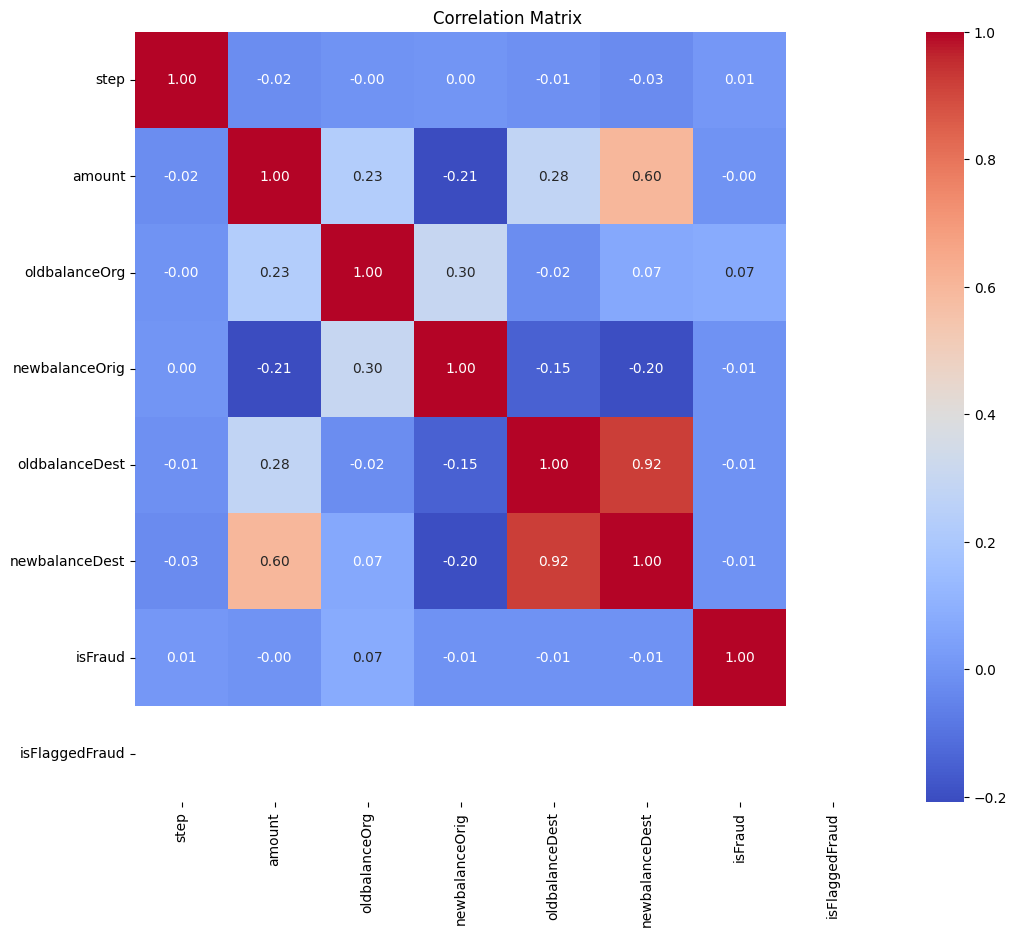

In [34]:
# Missing values
numeric_cols = data.select_dtypes(include='number').columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

categorical_cols = data.select_dtypes(include='object').columns
data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])

# Outlier removal (IQR method, skip amount & isFraud)
outlier_cols = [col for col in numeric_cols if col not in ['isFraud','amount']]
for col in outlier_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    data = data[(data[col] >= lower) & (data[col] <= upper)]

print("Fraud distribution after cleaning:\n", data['isFraud'].value_counts())

# Correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(data[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


## Feature Engineering

- Dropping identifiers (`nameOrig`, `nameDest`)  
- Dropping rule-based flag (`isFlaggedFraud`)  
- Encoding categorical variable `type`  
- Scaling numeric features


In [36]:
# Drop non-predictive columns
data = data.drop(columns=['nameOrig','nameDest','isFlaggedFraud'], errors='ignore')

# Features and target
X = data.drop("isFraud", axis=1)
y = data["isFraud"]

# One-hot encode 'type'
X = pd.get_dummies(X, columns=['type'], drop_first=True)

# Scale numeric features
numeric_cols = X.select_dtypes(include='number').columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

print("Class balance:\n", y.value_counts())


Class balance:
 isFraud
0    3374757
1       2431
Name: count, dtype: int64


In [37]:
# Train-Test Split (stratify keeps fraud ratio consistent)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)
print("Fraud in train:", y_train.sum(), "Fraud in test:", y_test.sum())


Train: (2701750, 10) Test: (675438, 10)
Fraud in train: 1945 Fraud in test: 486


## Baseline Model (Logistic Regression)

In [38]:
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:,1]
print("Baseline Logistic Regression ROC-AUC:", roc_auc_score(y_test, y_proba_lr))


Baseline Logistic Regression ROC-AUC: 0.99173568117656


## Model Training – XGBoost

XGBoost is chosen as it handles imbalanced data well and provides feature importance.


In [39]:
# Handle class imbalance with scale_pos_weight for XGBoost
n_pos = y_train.sum()
imbalance_ratio = (len(y_train)-n_pos)/n_pos
print("scale_pos_weight:", imbalance_ratio)

if xgb_available:
    model = XGBClassifier(
        scale_pos_weight=imbalance_ratio,
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
else:
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

model.fit(X_train, y_train)



scale_pos_weight: 1388.0745501285346


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Model Evaluation

Metrics used:
- Classification Report (Precision, Recall, F1-score)
- ROC-AUC Score
- Confusion Matrix


              precision    recall  f1-score   support

           0     1.0000    0.9893    0.9946    674952
           1     0.0625    0.9897    0.1175       486

    accuracy                         0.9893    675438
   macro avg     0.5312    0.9895    0.5561    675438
weighted avg     0.9993    0.9893    0.9940    675438

ROC-AUC Score: 0.9993161242083388


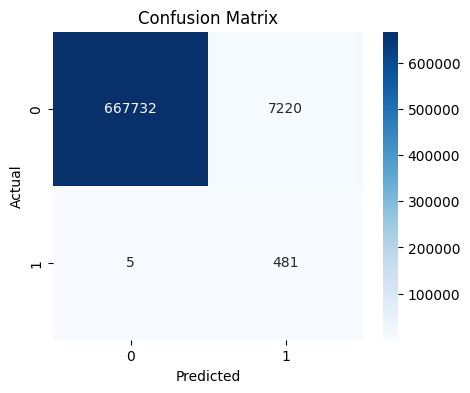

In [41]:
# Model Evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Metrics
print(classification_report(y_test, y_pred, digits=4))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



## Feature Importance

We extract the most important features from the model to understand what drives fraud detection.


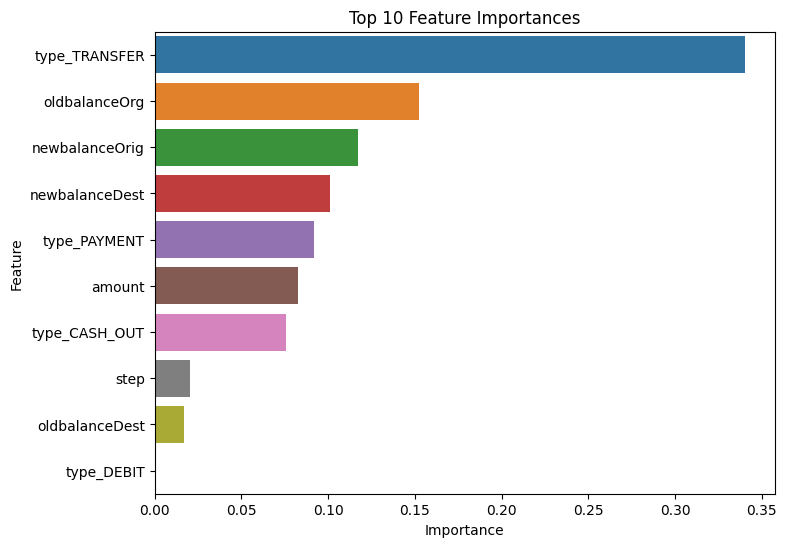

Top fraud predictors:
           Feature  Importance
9   type_TRANSFER    0.340419
2   oldbalanceOrg    0.152655
3  newbalanceOrig    0.117384
5  newbalanceDest    0.101180
8    type_PAYMENT    0.092008
1          amount    0.082843
6   type_CASH_OUT    0.075608
0            step    0.020108
4  oldbalanceDest    0.016872
7      type_DEBIT    0.000922


In [42]:
# Feature Importance

importance = model.feature_importances_
feat_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=feat_importance.head(10), x='Importance', y='Feature')
plt.title("Top 10 Feature Importances")
plt.show()

print("Top fraud predictors:\n", feat_importance.head(10))


## Precision-Recall Curve & PR-AUC

PR-AUC: 0.7884692265445092


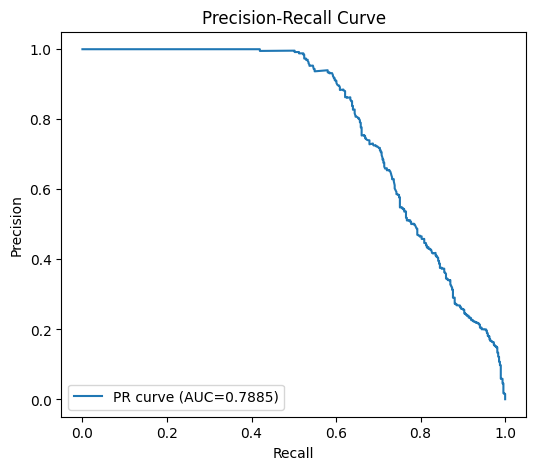

In [43]:
# Precision-Recall Curve & PR-AUC
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
print("PR-AUC:", pr_auc)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'PR curve (AUC={pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


## Threshold Tuning / Business Cost

Optimal threshold: 0.96 Cost: 14150


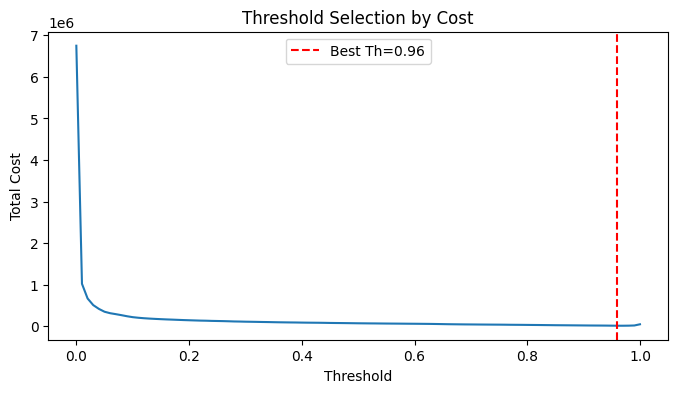

In [44]:

# Threshold Tuning / Business Cost
cost_fn = 100
cost_fp = 10
thresholds_to_try = np.linspace(0,1,101)
costs = []

for th in thresholds_to_try:
    y_pred_thresh = (y_proba >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    total_cost = fn*cost_fn + fp*cost_fp
    costs.append(total_cost)

best_idx = np.argmin(costs)
best_th = thresholds_to_try[best_idx]
print("Optimal threshold:", best_th, "Cost:", costs[best_idx])

plt.figure(figsize=(8,4))
plt.plot(thresholds_to_try, costs)
plt.axvline(best_th, color='red', linestyle='--', label=f'Best Th={best_th:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Total Cost')
plt.title('Threshold Selection by Cost')
plt.legend()
plt.show()


## Normalized Cost Matrix 

In [45]:

# Normalized Cost Matrix Example
tn, fp, fn, tp = confusion_matrix(y_test, (y_proba >= best_th).astype(int)).ravel()
cost_matrix = np.array([[0, cost_fp],
                        [cost_fn, 0]])
normalized_cost_matrix = cost_matrix / cost_matrix.sum()
print("Normalized cost matrix:\n", normalized_cost_matrix)



Normalized cost matrix:
 [[0.         0.09090909]
 [0.90909091 0.        ]]


In [47]:
#Model Saving & Reproducibility
joblib.dump(model, "fraud_detection_model.pkl")
print("Model saved as fraud_detection_model.pkl")


Model saved as fraud_detection_model.pkl
